<a href="https://colab.research.google.com/github/MNITImpostors/SkinVision/blob/master/outlier_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools


In [62]:
#Reference-https://gist.github.com/mstfldmr/44dfce35f5330b22ee1e3b28ca91a3e7
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', input_shape=(224,224,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))


model.add(Conv2D(8,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model.add(Conv2D(8,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model.add(Conv2D(8,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(8,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))


model.add(Conv2D(16,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))


model.add(Conv2D(3,(3, 3), padding='same'))
model.add(Activation('sigmoid'))

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy')


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
activation_5 (Activation)    (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 8)       1160      
_________________________________________________________________
activation_6 (Activation)    (None, 112, 112, 8)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 8)        

In [63]:
read = lambda imname: np.asarray(Image.open(imname).resize((224,224),Image.ANTIALIAS).convert("RGB"))

In [64]:
benign_folder='/content/drive/MyDrive/data/train/benign'
mal_folder='/content/drive/MyDrive/data/train/malignant'
X_benign=np.array([read(os.path.join(benign_folder,file)) for file in os.listdir(benign_folder)])
X_malignant=np.array([read(os.path.join(mal_folder,file))for file in os.listdir(mal_folder)])


In [65]:
X=np.concatenate((X_benign,X_malignant),axis=0)

In [66]:
X_train=X[:int(0.8*X.shape[0])]
X_test=X[int(0.8*X.shape[0]):]

In [67]:
X_train=X_train/255.0
X_test=X_test/255.0

In [68]:
model.fit(X_train,X_train,epochs=10,batch_size=128,validation_data=(X_test,X_test))

Epoch 1/10
17/17 [==============================] - 168s 10s/step - loss: 0.6714 - val_loss: 0.6790
Epoch 2/10
17/17 [==============================] - 174s 10s/step - loss: 0.6319 - val_loss: 0.6564
Epoch 3/10
17/17 [==============================] - 174s 10s/step - loss: 0.6277 - val_loss: 0.6539
Epoch 4/10
17/17 [==============================] - 175s 10s/step - loss: 0.6251 - val_loss: 0.6501
Epoch 5/10
17/17 [==============================] - 175s 10s/step - loss: 0.6192 - val_loss: 0.6365
Epoch 6/10
17/17 [==============================] - 174s 10s/step - loss: 0.6131 - val_loss: 0.6315
Epoch 7/10
17/17 [==============================] - 173s 10s/step - loss: 0.6068 - val_loss: 0.6275
Epoch 8/10
17/17 [==============================] - 174s 10s/step - loss: 0.6020 - val_loss: 0.6233
Epoch 9/10
17/17 [==============================] - 174s 10s/step - loss: 0.5970 - val_loss: 0.6160
Epoch 10/10
17/17 [==============================] - 172s 10s/step - loss: 0.5933 - val_loss: 0.6128

In [69]:
from skimage.color import rgb2grey
from sklearn.cluster import KMeans

In [70]:
def mask(img):
  cluster_img=(KMeans(n_clusters=2).fit(rgb2grey(img).reshape(-1,1)).labels_.reshape(224,224))
  masks=[cluster_img==i for i in range(2)]
  a=(rgb2grey(img)*masks[0]).mean()
  b=(rgb2grey(img)*masks[1]).mean()
  x=0
  if a<b :
    x=0
  else:
    x=1  
  y=img.copy() 
  for i in range(3):
    y[:,:,i]*=masks[x]
  return y    
   


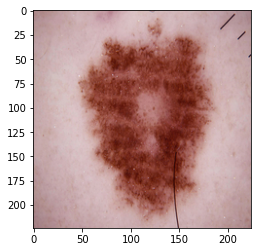

In [83]:
plt.imshow(read('1058.jpg'))

In [84]:
x=read('1058.jpg')
x=x/255.
ax=model.predict(x.reshape(-1,224,224,3))[0]

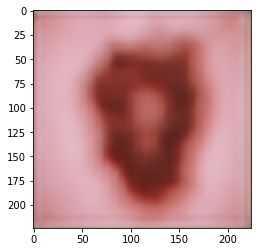

In [85]:
plt.imshow(model.predict(x.reshape(-1,224,224,3))[0])

In [86]:
np.mean((x-ax)**2)

0.004227808872348843

In [75]:
model_json = model.to_json()

with open("autoencoder.json", "w") as json_file:
    json_file.write(model_json)
    

model.save_weights("autoencoder.h5")